In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import sparselt.esmf
import sparselt.xr
from fv3_mass_flux_tools.convert import convert_mass_fluxes_to_winds, convert_winds_to_mass_fluxes, get_full_mfxc_delpx
from fv3_mass_flux_tools.interpolate import cgrid_to_agrid, agrid_to_cgrid_interior_only

## Convert mass flux (C-grid) to wind (A-grid)
GEOS-FP generates mass fluxes. When we use these mass fluxes in GCHP, vertical transport is correct because the divergence of the horizontal mass fluxes is correct.

Normally, we drive GCHP with A-grid wind fields. These A-grid winds are generated at GMAO by converting the mass fluxes (C-grid) to winds (C-grid) and then restaggering the C-grid winds to an A-grid. The problem is an A-grid vector quantity cannot preserve divergence, hence the errors we see in vertical transport in GCHP.

The code below calculates A-grid winds, as GMAO does. This operation is lossy. After calculating the A-grid winds, we will "undo" the calculation to quantify the error incurred in divergence.

In [ ]:
tavg_1hr_ctm = xr.open_dataset("data/GEOS.fp.asm.tavg_1hr_ctm_c0720_v72.20210401_0030.V01.nc4")
grid = xr.open_mfdataset([f"data/c720.tile{i}.nc" for i in range(1,7)], concat_dim='nf', combine='nested')
uc, vc = convert_mass_fluxes_to_winds(tavg_1hr_ctm, grid, 1)  # divergence should still be correct here
ua, va = cgrid_to_agrid(uc, vc)  # divergence should have errors here; this is what GCHP uses for wind

In [ ]:
# plot U component of wind (a-grid) for reference
xx_corner_face = grid.lons.isel(nf=1, xc=slice(0,None,2), yc=slice(0,None,2))
yy_corner_face = grid.lats.isel(nf=1, xc=slice(0,None,2), yc=slice(0,None,2))
lev=32
u_a_face = ua[0, lev, ...]

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.pcolormesh(xx_corner_face, yy_corner_face, u_a_face, transform=ccrs.PlateCarree())
plt.show()

To simplify the problem, lets consider a line along the equator. This line is shown below in red.

In [ ]:
# to simplify the problem, draw a line along the equator
line_along_equator = dict(nf=1, xc=slice(1,None,2), yc=720)
xa = grid.lons.isel(**line_along_equator)
ya = grid.lats.isel(**line_along_equator)

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.pcolormesh(xx_corner_face, yy_corner_face, u_a_face, transform=ccrs.PlateCarree())
plt.plot(xa, ya, transform=ccrs.PlateCarree(), lw=4, color='red')
plt.show()

Next, we will calculate the C-grid mass fluxes from the A-grid winds. This is the operation that GCHP performs internally, to convert the input wind data to the form used by FV3 advection calculation. 

In [ ]:
# undoing mass flux -> wind conversion
uc_undo = np.ones_like(uc) * np.nan
vc_undo = np.ones_like(vc) * np.nan

uc_undo[...,1:-1], vc_undo[...,1:-1,:] = agrid_to_cgrid_interior_only(ua, va)  # I haven't implemented c->a conversion at face edges
mfxc_undo, mfyc_undo = convert_winds_to_mass_fluxes(tavg_1hr_ctm, grid, 1, uc_undo, vc_undo)

Now we should see an error in the X-component of the mass flux. (Only considering X-component along the red line)

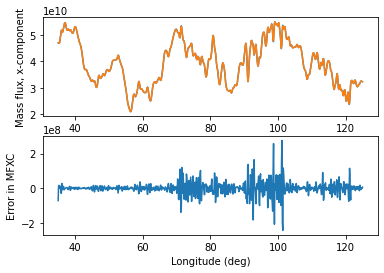

In [47]:
line_along_equator = dict(nf=1, xc=slice(0, None, 2), yc=720)
xc = grid.lons.isel(**line_along_equator).values  # longitudes along red line (c-grid)

nf = 1
mfxc, delpx = get_full_mfxc_delpx(tavg_1hr_ctm, nf)
mfxc_along_equator = mfxc[0, lev, 360, :]

mfxc_undo_along_equator = mfxc_undo[0, lev, 360, :]

plt.figure()
plt.subplot(2,1,1)
plt.plot(xc, mfxc_along_equator)
plt.plot(xc, mfxc_undo_along_equator)
plt.xlabel('Longitude (deg)')
plt.ylabel('Mass flux, x-component')
plt.subplot(2,1,2)
plt.plot(xc, mfxc_undo_along_equator - mfxc_along_equator)
plt.xlabel('Longitude (deg)')
plt.ylabel('Error in MFXC')
plt.show()

The error in the divergence (1-dimensional here) is ultimately what we are concerned about. This translates to spurious vertical motion in the model.

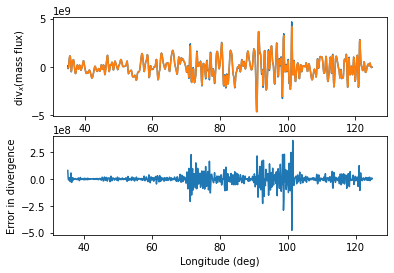

In [46]:
#div_mfxc = np.diff(mfxc,)
line_along_equator = dict(nf=1, xc=slice(1, None, 2), yc=720)
xa = grid.lons.isel(**line_along_equator).values  # longitudes along red line (c-grid)
div_mfxc_along_equator = np.diff(mfxc_along_equator)
div_mfxc_undo_along_equator = np.diff(mfxc_undo_along_equator)

plt.figure()
plt.subplot(2,1,1)
plt.plot(xa, div_mfxc_along_equator)
plt.plot(xa, div_mfxc_undo_along_equator)
plt.xlabel('Longitude (deg)')
plt.ylabel('div$_x$(mass flux)')
plt.subplot(2,1,2)
plt.plot(xa, div_mfxc_undo_along_equator - div_mfxc_along_equator)
plt.xlabel('Longitude (deg)')
plt.ylabel('Error in divergence')
plt.show()

**Problem:** Can we find correction factors to apply to `mfxc_undo_along_equator` such that `div(mfxc_undo_along_equator) == div(mfxc_along_equator)`.

$$
div(M_x)
=
\left(\begin{array}{cccc} 
M_{x1} & M_{x2} & M_{x3} & M_{x4} \\
\end{array}\right)
\left(\begin{array}{ccc} 
C_1 & 0 & 0 \\
-C_2 & C_2 & 0 \\
0 & -C_3 & C_3 \\
0 & 0 & -C_4 \\
\end{array}\right)
$$ 

where $M_{xn}$ is the x-component of mass flux along the red line, as calculated by GCHP (or `mfxc_undo_along_equator` here), $div(M_x)$ is the erroneous divergence. Can we find $(C_1, C_2, ..., C_n)$ such that $div(M_x)$ equals the "correct divergence". If we can, then we could archive this "correct divergence" and use it to "tweak" the mass fluxes that GCHP calculates from the A-grid winds so that the divergence of the resulting field is correct.

In [73]:
# scratch

correct_divergence = np.diff(mfxc_along_equator)
divergence = np.diff(mfxc_undo_along_equator)

n = mfxc_undo_along_equator.size
scale_factors = np.ones_like(n)
M = np.zeros((n, n-1))
for i in range(n-1):
    M[i,i] = -1
    M[i+1,i] = 1
    
tweak_factors = np.ones(n)

D = M*tweak_factors[:,np.newaxis]
div = mfxc_along_equator @ D